**[Intermediate Machine Learning Home Page](https://www.kaggle.com/learn/intermediate-machine-learning)**

---


**In this notebook, I am going to perform data processing and build machine learning model for the "House Price Competition" on Kaggle**


# Importing Libraries

In [31]:

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Read the Data

In [32]:
import pandas as pd
X_train = pd.read_csv('../input/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/test.csv', index_col='Id')

In [33]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


To unify the train and test data for the purpose of analysis.
We concatenate the train and test together, as a whole X DataFrame

In [35]:
X =  pd.concat([X_train.drop('SalePrice', axis=1), X_test], axis = 0)
y = X_train[['SalePrice']]

 # Analyze Variables with too many missing values 

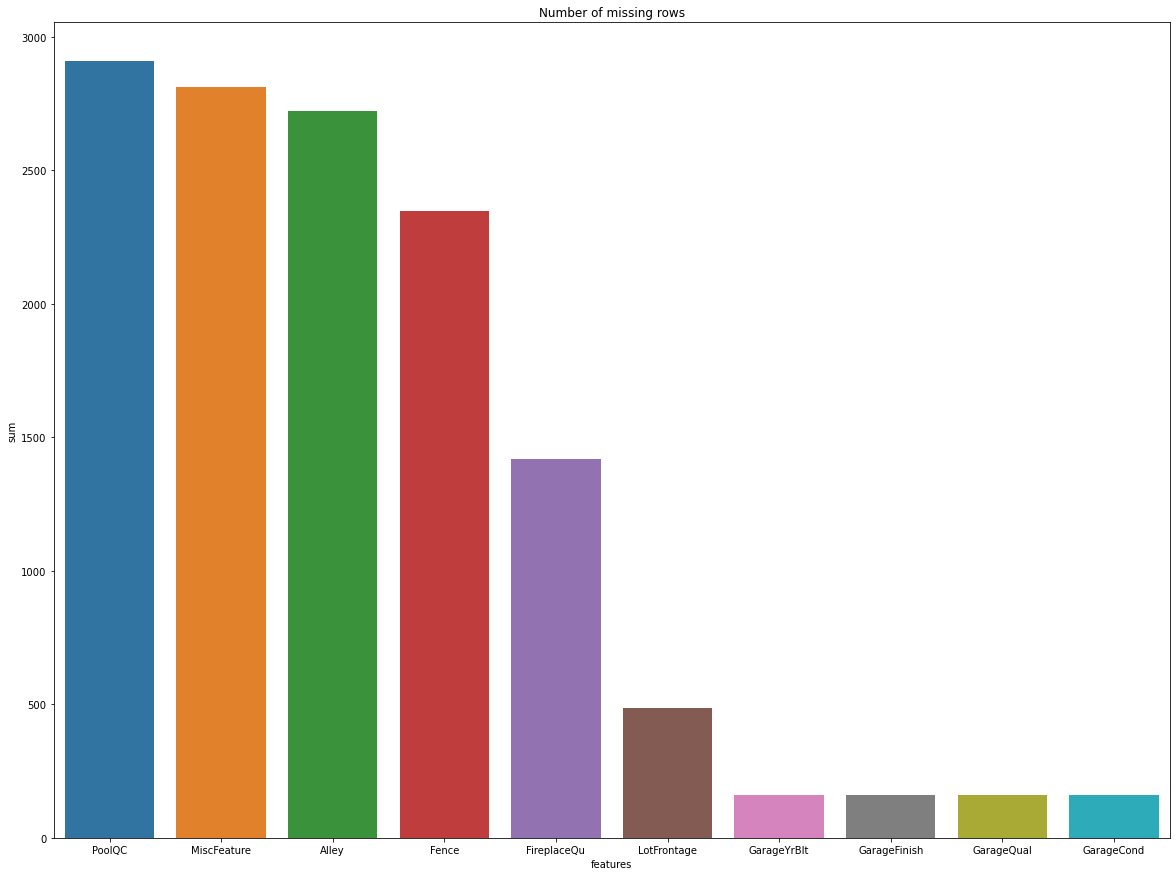

In [36]:
fig_1 = plt.figure(figsize=(20,15))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count.iloc[:10])

From the plot, we choose to drop the first 4 columns that have too many missing values: PoolQC, MiscFeature, Alley, Fence. Those columns will have no valuable contribution to the price prediction due to too many missing.

In [37]:
X.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1, inplace = True)

# Categorical Variables: Fill missing Values

### Ordinal variable: Fill NA
Ordinal variable is categorical type but show a clear ordering of the variable. Example: 'Good', 'Medium', 'Bad'. For this type of variable, we fill 'NA'

In [38]:
ordinal_features = ['BsmtCond','BsmtQual','ExterCond','ExterQual','FireplaceQu',
                    'GarageCond','GarageQual','HeatingQC','KitchenQual',
                    'BsmtFinType1','BsmtFinType2','BsmtExposure']
X[ordinal_features] = X[ordinal_features].fillna('NA')

### Other categorical variables: Fill with 'most frequent'

In [39]:
catego_features = ['Electrical','Exterior1st','Exterior2nd','MasVnrType',
                    'SaleType','GarageFinish','GarageType','Utilities', 'Functional']
for col in catego_features:
    X[col] =X[col].fillna(X[col].value_counts().index[0])

### Special variable
The variable 'MSZoning' has a strong relationship with the 'MSSubClass' variable. Therefore, we fill NA for this variable, in accordance to the 'MSSubClass' variable

In [40]:
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].apply(
        lambda x: x.fillna(x.mode()[0]))

# Ordinal Variable: Mapping

Ordinal columns with values of: Ex, Gd, TA, Fa, Po, NA. We map with the numeric values range from 5 --> 0

In [41]:
ordinal_map = {'Ex': 5, 'Gd' : 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
ordinal_col = ['BsmtCond','BsmtQual','ExterCond','ExterQual','FireplaceQu',
                    'GarageCond','GarageQual','HeatingQC','KitchenQual']
for col in ordinal_col:
    X[col]= X[col].map(ordinal_map)

Ordinal columns with values of: GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA  We map with the value range from 6 --> 0

In [42]:
ordinal_fin_map     = {'GLQ': 6, 'ALQ': 5, 'BLQ' : 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
ordinal_fin_col = ['BsmtFinType1','BsmtFinType2']
for col in ordinal_fin_col:
    X[col]= X[col].map(ordinal_fin_map)

Ordinal columns with values of: Gd, Av, Mn, No, NA. We map with the value range from 4 --> 0

In [43]:
ordinal_expose_map  = {'Gd': 4, 'Av' : 3, 'Mn': 2, 'No': 1, 'NA': 0}
X['BsmtExposure']  = X['BsmtExposure'].map(ordinal_expose_map)

'Neighborhood' variable has a strong relation with the SalePrice. Depending on the location of Neighborhood, the average price will fluctuate along. Therefore, we will map the value of this variable in according to the average SalePrice 

In [61]:
print('Average SalePrice in each Neighborhood')
X_train.groupby('Neighborhood').SalePrice.mean().sort_values()

Average SalePrice in each Neighborhood


Neighborhood
MeadowV     98576.470588
IDOTRR     100123.783784
BrDale     104493.750000
BrkSide    124834.051724
Edwards    128219.700000
OldTown    128225.300885
Sawyer     136793.135135
Blueste    137500.000000
SWISU      142591.360000
NPkVill    142694.444444
NAmes      145847.080000
Mitchel    156270.122449
SawyerW    186555.796610
NWAmes     189050.068493
Gilbert    192854.506329
Blmngtn    194870.882353
CollgCr    197965.773333
Crawfor    210624.725490
ClearCr    212565.428571
Somerst    225379.837209
Veenker    238772.727273
Timber     242247.447368
StoneBr    310499.000000
NridgHt    316270.623377
NoRidge    335295.317073
Name: SalePrice, dtype: float64

In [45]:
neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10}

X['Neighborhood']  = X['Neighborhood'].map(neigh_map)

# Numerical Variables: Fill missing Values

Some variable: LotFrontage, GarageCars have a strong relation with Neighborhood. Therefore, we fill NA according to each Neighborhood

In [46]:
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageCars'] = X.groupby('Neighborhood')['GarageCars'].transform(lambda x: x.fillna(x.mean()))

For other numerical columns, simply fill with 0

In [47]:
other_nume_col = ["MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1",
                  "BsmtUnfSF", "TotalBsmtSF", "BsmtFinSF2",'GarageYrBlt',
                  'GarageArea']
X[other_nume_col] = X[other_nume_col].fillna(0)

# Changing data type
Some numerical variable are actually categorical variable, so we change theirs data type

In [48]:
X['MSSubClass'] = X['MSSubClass'].apply(str)
X['YrSold'] = X['YrSold'].apply(str)
X['MoSold'] = X['MoSold'].apply(str)

# Analysis of Numeric Data

After filling all NA for both categorical and numerical variable, we move on to further analysis of data

### Dealing with Outliers
We use scatter plot to analyse Outliers

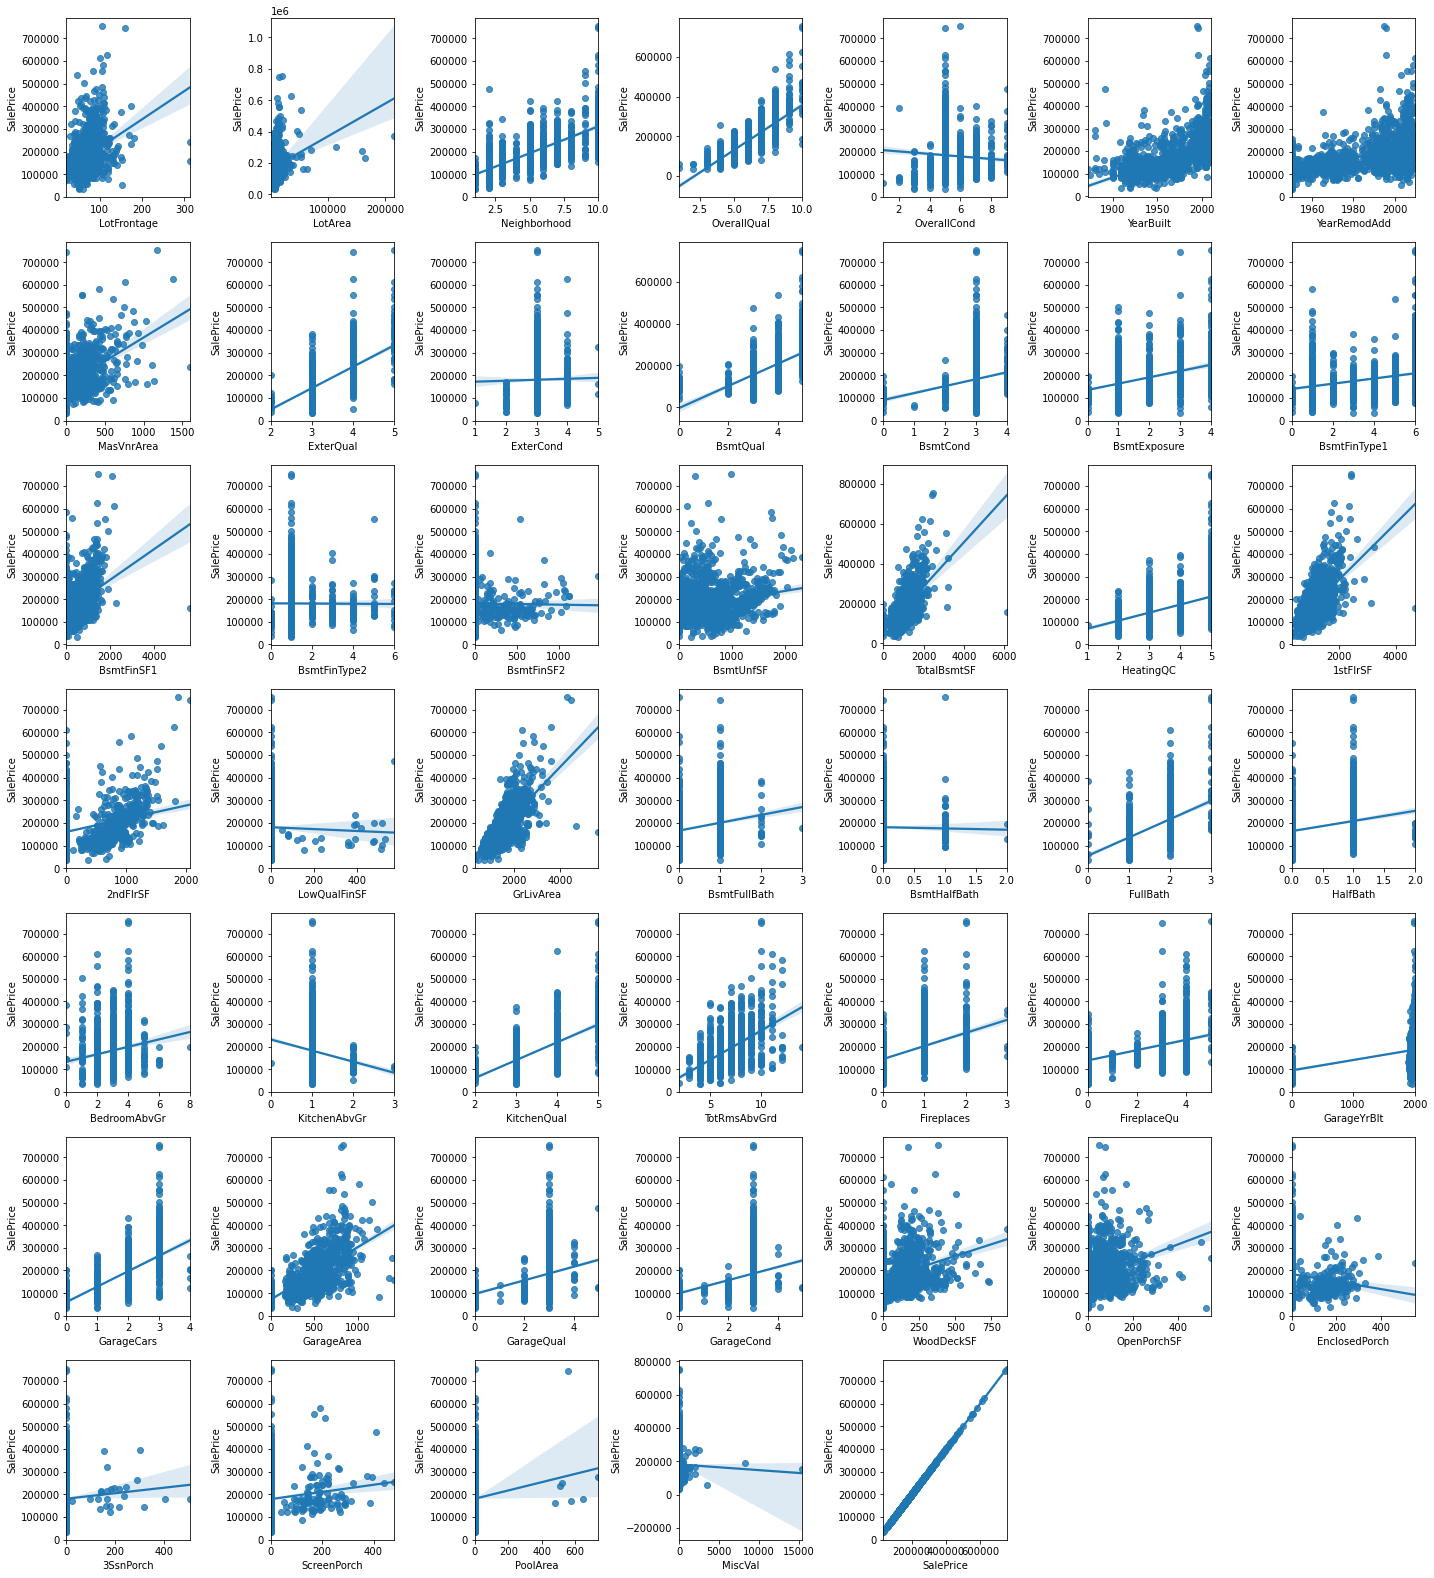

In [49]:
fig2 = plt.figure(figsize = (20,22))
X_numeric = X.select_dtypes(exclude = ['object']).iloc[0:1460,:]
X_numeric = pd.concat([X_numeric, y], axis = 1)
for index, col in enumerate(X_numeric.columns, 1):
    plt.subplot(7, 7, index)
    sns.regplot(x = col, y = 'SalePrice', data = X_numeric)
fig2.tight_layout(pad=1.0)

From the scatter plot, we drop some outliers

In [50]:
X = X.join(y)
X = X.drop(X[(X['OverallQual'] < 5)
                                  & (X['SalePrice'] > 200000)].index)
X = X.drop(X[(X['GrLivArea'] > 4000)
                                  & (X['SalePrice'] < 200000)].index)
X = X.drop(X[(X['GarageArea'] > 1200)
                                  & (X['SalePrice'] < 200000)].index)
X = X.drop(X[(X['TotalBsmtSF'] > 6000)
                                  & (X['SalePrice'] < 200000)].index)
X = X.drop(X[(X['1stFlrSF'] < 3000)
                                  & (X['SalePrice'] > 700000)].index)
X = X.drop(X[(X['1stFlrSF'] > 4000)
                                  & (X['SalePrice'] < 200000)].index)

y = X['SalePrice']
y.dropna(inplace = True)
X.drop(columns ='SalePrice', inplace = True)

### Creating some new variable
By combining some variables together, we would have stronger predictors

In [51]:
X['TotalSF'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF'])
X['TotalBathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
X['TotalPorchSF'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
X['YearBlRm'] = (X['YearBuilt'] + X['YearRemodAdd'])

### Merging quality and conditions

In [52]:
X['TotalExtQual'] = (X['ExterQual'] + X['ExterCond'])
X['TotalBsmQual'] = (X['BsmtQual'] + X['BsmtCond'] + X['BsmtFinType1'] +  X['BsmtFinType2'])
X['TotalGrgQual'] = X['GarageQual'] + X['GarageCond']
X['TotalQual'] = (X['OverallQual']   + X['TotalExtQual']    + X['TotalBsmQual']  + X['TotalGrgQual'] 
                                                            + X['KitchenQual']   + X['HeatingQC'])

### Creating new features by using new quality indicators

In [53]:
X['QualGr'] = X['TotalQual'] * X['GrLivArea']
X['QualBsm'] = X['TotalBsmQual'] * (X['BsmtFinSF1'] + X['BsmtFinSF2'])
X['QualPorch'] = X['TotalExtQual'] * X['TotalPorchSF']
X['QualExt'] = X['TotalExtQual'] * X['MasVnrArea']
X['QualGrg'] = X['TotalGrgQual'] * X['GarageArea']
X['QlLivArea'] = (X['GrLivArea'] - X['LowQualFinSF']) * (X['TotalQual'])
X['QualSFNg'] = X['QualGr'] * X['Neighborhood']


### Creating some simple features

In [ ]:
X['HasPool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
X['Has2ndFloor'] = X['2ndFlrSF'].apply(lambda x: 1
                                                     if x > 0 else 0)
X['HasGarage'] = X['QualGrg'].apply(lambda x: 1 if x > 0 else 0)
X['HasBsmt'] = X['QualBsm'].apply(lambda x: 1 if x > 0 else 0)
X['HasFireplace'] = X['Fireplaces'].apply(lambda x: 1
                                                        if x > 0 else 0)
X['HasPorch'] = X['QualPorch'].apply(lambda x: 1 if x > 0 else 0)

# Dealing with Skewness

In [54]:
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p
skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal']

# Finding skewness of the numerical features
skew_features = np.abs(X[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features
high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew
skew_index = high_skew.index

# Applying boxcox transformation to fix skewness
for i in skew_index:
    X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


# Dropping useless variable

In [55]:
# Features to drop, unuseful features
to_drop = [
    'Utilities',
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC']

# Dropping features
X.drop(columns=to_drop, inplace=True)

# Getting dummy variables for categorical data

In [56]:
X = pd.get_dummies(data=X)

# Separating train and test set

In [57]:
train = X.iloc[:len(y), :]
test = X.iloc[len(train):, :]

# Machine Learning Model

In this project, we will builld and optimize model with Gradient Boosting
An implementation of Gradient Boosting, which is XGBOOST: Extreme Gradient Boosting, will be used

Dealing with skewness of SalePrice

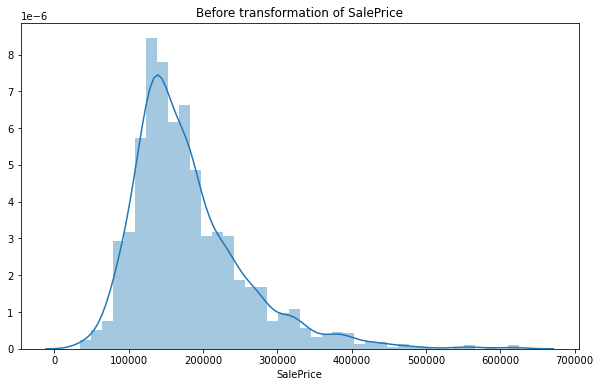

In [65]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
#y = np.log(y)
dist = sns.distplot(y,norm_hist=False)

We use log transformation to solve the skewness problem of SalePrice

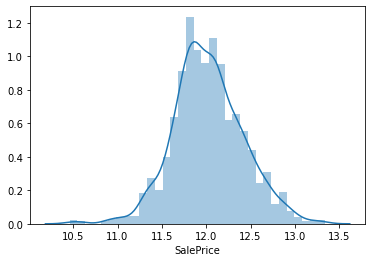

In [66]:
y = np.log(y)
dist = sns.distplot(y,norm_hist=False)

In [58]:
x_just_train, x_just_val, y_just_train, y_just_val = train_test_split(train, y, test_size=0.2, random_state=1)

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(train, y, 
             early_stopping_rounds=5, 
             eval_set=[(x_just_val, y_just_val)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
prediction_1 = my_model.predict(test)
prediction = np.exp(prediction_1)
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': prediction})
output.to_csv('submission.csv', index=False)